In [ ]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd 
import kagglehub
import os 
import shutil
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
# Dataset downloading and importing as pandas DataFrame
path = kagglehub.dataset_download("mirichoi0218/insurance") 

for file in os.listdir(path):
    src = os.path.join(path, file)
    dst = os.path.join(".", file)
    shutil.copy2(src, dst)
    print(f"Copied {file} to current directory")

print("Path to dataset files:", path)

df=pd.read_csv("insurance.csv")

In [ ]:
df.info()

In [ ]:
# question - how many unique region values are there in the dataset?
print(df['region'].nunique())
# answer is 4 

In [ ]:
# handling categorical variables
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['sex','smoker','region']
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[categorical_cols])
# To get the encoded columns as a DataFrame and join with the original data:
encoded_df=pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))
df_encoded=pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

In [ ]:
# for MLR we have to check that each feature is linearly related to target variable and independent variables are not highly correlated with each other

# we can check linear relationship by scatter plot , pearson correlation coefficient, or regplot 
import seaborn as sns

# Exclude categorical columns for regression plots
numeric_cols = [col for col in df.columns if col not in categorical_cols + ['charges']]

for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    sns.scatterplot(x=df[col], y=df['charges'])
    plt.title(f'Regression Plot: {col} vs Charges')
    plt.xlabel(col)
    plt.ylabel('Charges')
    plt.show()
    
# lets draw a heatmap to check correlation between features using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# no two features are highly correlated with each other, so we can proceed with multiple linear regression

In [ ]:
X= df_encoded.drop(columns=['charges'])
y= df_encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# model building 

model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
# model prediction of x_test to get y_pred that will be compared with y_test 
y_pred = model.predict(X_test)  
print(y_pred.shape, y_test.shape)                                                   

In [19]:
# model evaluation
mae= mean_absolute_error(y_pred, y_test)
mse= mean_squared_error(y_pred, y_test)
rmse= np.sqrt(mse)
r2=r2_score(y_pred, y_test)

In [20]:
metrics = {
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'Mean Charges': df['charges'].mean(),
    'Median Charges': df['charges'].median()
}

# Create DataFrame with two columns
results_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
# Prevent scientific notation for easier reading
pd.set_option('display.float_format', '{:.2f}'.format)

print(results_df)

           Metric       Value
0             MAE     4181.19
1             MSE 33596915.85
2            RMSE     5796.28
3              R2        0.71
4    Mean Charges    13270.42
5  Median Charges     9382.03


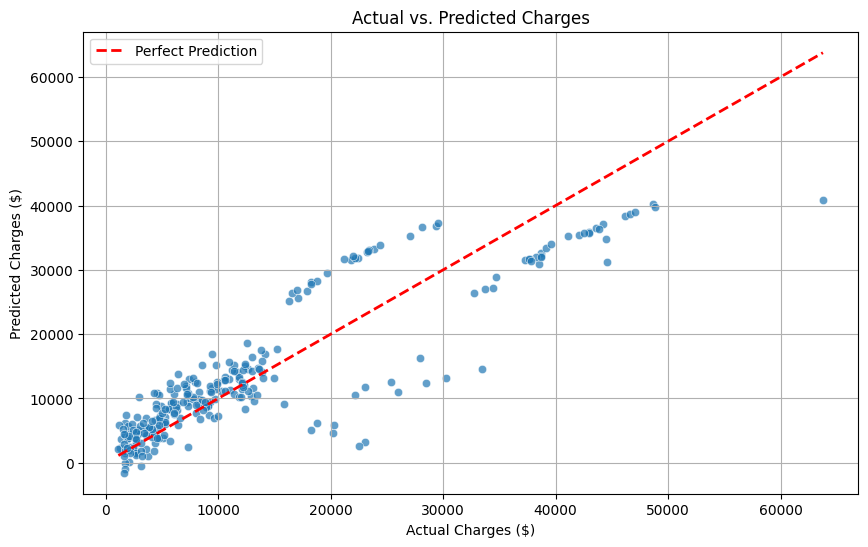

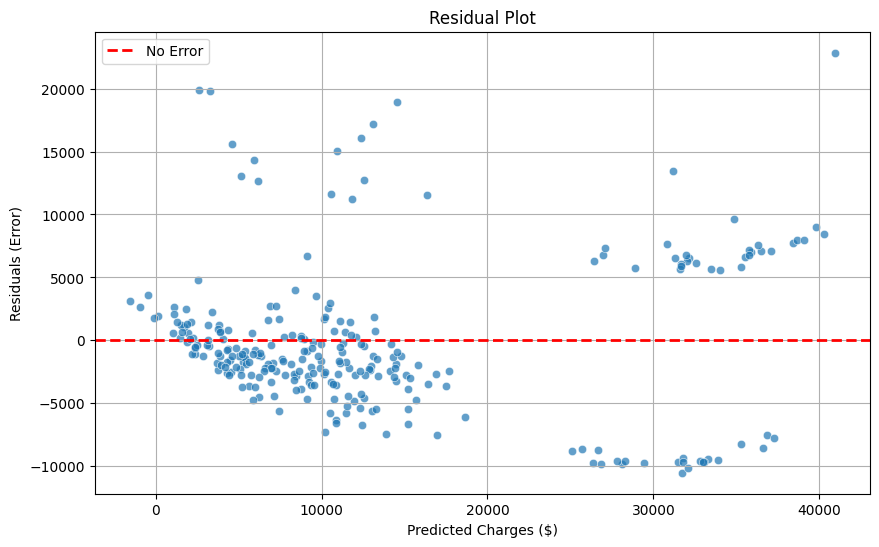

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- VISUALIZATIONS using Seaborn ---

# 1. Predicted vs. Actual Plot
# This plot shows how close the model's predictions are to the actual values.
# A perfect model would have all points on the red dashed line.
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Charges ($)')
plt.ylabel('Predicted Charges ($)')
plt.title('Actual vs. Predicted Charges')
plt.legend()
plt.grid(True)
plt.show()


# 2. Residual Plot
# This plot helps diagnose the model's errors.
# We want to see a random scatter of points around the y=0 line.
# Patterns (like a cone or a curve) indicate problems with the model.
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', lw=2, label='No Error')
plt.xlabel('Predicted Charges ($)')
plt.ylabel('Residuals (Error)')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# model is not performing good for high charges by looking at scatter plot it generally predicts bad after 15000$ mark . 

# reason could be lack of data for high charges or non-linearity in the relationship between features and charges at higher values.

# --- Check Data Distribution ---
threshold = 15000

# Count data points below and above the threshold
below_threshold_count = df[df['charges'] < threshold].shape[0]
above_threshold_count = df[df['charges'] >= threshold].shape[0]

total_count = len(df)

# Calculate percentages
below_percentage = (below_threshold_count / total_count) * 100
above_percentage = (above_threshold_count / total_count) * 100

print(f"Data points with charges < ${threshold}: {below_threshold_count} ({below_percentage:.2f}%)")
print(f"Data points with charges >= ${threshold}: {above_threshold_count} ({above_percentage:.2f}%)")

Data points with charges < $15000: 980 (73.24%)
Data points with charges >= $15000: 358 (26.76%)


In [ ]:
# intuition is right . we have insufficient data for high charges which is causing the model to perform poorly in that range.